In [1]:
from __future__ import division
import pyhull
import string
import math
import numpy as np
from pylab import*
from pytope import Polytope
from scipy.spatial import ConvexHull

In [2]:
def traj(x0, u, omega, t):
    
    n_steps = len(t)
    dt = t[1]-t[0]

    # initial condition
    xs = x0
    out_xr = []
    
    tc = n_steps/(omega_t.shape[0]) # time of changing velocity
    
    for i in range(n_steps):
        
        # change of velocity
        if i % tc == 0:
            w = omega[int(i//tc)] #ut[int(i//tc*2)+1]
            if w == 0:
                v = u
            else:
                v = 1
        
        # store data
        out_xr.append(xs) # reference trajectory
        # Propagate reference
        xs = xs + dt*np.array([v*cos(xs[2]), v*sin(xs[2]), w])


    x = np.array(out_xr)
    return x

In [3]:
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [4]:
def minBoundingRect(hull_points_2d):
    #print "Input convex hull points: "
    #print hull_points_2d

    # Compute edges (x2-x1,y2-y1)
    edges = zeros( (len(hull_points_2d)-1,2) ) # empty 2 column array
    for i in range( len(edges) ):
        edge_x = hull_points_2d[i+1,0] - hull_points_2d[i,0]
        edge_y = hull_points_2d[i+1,1] - hull_points_2d[i,1]
        edges[i] = [edge_x,edge_y]
    #print "Edges: \n", edges

    # Calculate edge angles   atan2(y/x)
    edge_angles = zeros( (len(edges)) ) # empty 1 column array
    for i in range( len(edge_angles) ):
        edge_angles[i] = math.atan2( edges[i,1], edges[i,0] )
    #print "Edge angles: \n", edge_angles

    # Check for angles in 1st quadrant
    for i in range( len(edge_angles) ):
        edge_angles[i] = abs( edge_angles[i] % (math.pi/2) ) # want strictly positive answers
    #print "Edge angles in 1st Quadrant: \n", edge_angles

    # Remove duplicate angles
    edge_angles = unique(edge_angles)
    #print "Unique edge angles: \n", edge_angles

    # Test each angle to find bounding box with smallest area
    min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0, 0) # rot_angle, area, width, height, min_x, max_x, min_y, max_y
    #print("Testing", len(edge_angles), "possible rotations for bounding box... \n")
    for i in range( len(edge_angles) ):

        # Create rotation matrix to shift points to baseline
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = array([ [ math.cos(edge_angles[i]), math.cos(edge_angles[i]-(math.pi/2)) ], [ math.cos(edge_angles[i]+(math.pi/2)), math.cos(edge_angles[i]) ] ])
        #print "Rotation matrix for ", edge_angles[i], " is \n", R

        # Apply this rotation to convex hull points
        rot_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
        #print "Rotated hull points are \n", rot_points

        # Find min/max x,y points
        min_x = nanmin(rot_points[0], axis=0)
        max_x = nanmax(rot_points[0], axis=0)
        min_y = nanmin(rot_points[1], axis=0)
        max_y = nanmax(rot_points[1], axis=0)
        #print( "potential Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y)

        # Calculate height/width/area of this bounding rectangle
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        #print( "Potential bounding box ", i, ":  width: ", width, " height: ", height, "  area: ", area)

        # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
        if (area < min_bbox[1]):
            min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )
        # Bypass, return the last found rect
        #min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )

    # Re-create rotation matrix for smallest rect
    angle = min_bbox[0]   
    R = array([ [ math.cos(angle), math.cos(angle-(math.pi/2)) ], [ math.cos(angle+(math.pi/2)), math.cos(angle) ] ])
    #print "Projection matrix: \n", R

    # Project convex hull points onto rotated frame
    proj_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
    #print "Project hull points are \n", proj_points

    # min/max x,y points are against baseline
    min_x = min_bbox[4]
    max_x = min_bbox[5]
    min_y = min_bbox[6]
    max_y = min_bbox[7]
    #print( "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y)

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_point = dot( [ center_x, center_y ], R )
    #print "Bounding box center point: \n", center_point

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (4,2) ) # empty 2 column array
    corner_points[0] = dot( [ max_x, min_y ], R )
    corner_points[1] = dot( [ min_x, min_y ], R )
    corner_points[2] = dot( [ min_x, max_y ], R )
    corner_points[3] = dot( [ max_x, max_y ], R )
    x = np.array([corner_points[0][0], corner_points[1][0], corner_points[2][0], corner_points[3][0]])
    y = np.array([corner_points[0][1], corner_points[1][1], corner_points[2][1], corner_points[3][1]])
    x_bound = x.max()-x.min()
    y_bound = y.max()-y.min()
    #print "Bounding box corner points: \n", corner_points

    #print "Angle of rotation: ", angle, "rad  ", angle * (180/math.pi), "deg"

    return (angle, min_bbox[1], min_bbox[2], min_bbox[3], center_point, corner_points) # rot_angle, area, width, height, center_point, corner_points

In [5]:
link = lambda a,b: concatenate((a,b[1:]))
edge = lambda a,b: concatenate(([a],[b]))

def qhull2D(sample):
    link = lambda a,b: concatenate((a,b[1:]))
    edge = lambda a,b: concatenate(([a],[b]))
    def dome(sample,base): 
        h, t = base
        dists = dot(sample-h, dot(((0,-1),(1,0)),(t-h)))
        outer = repeat(sample, dists>0, 0)
        if len(outer):
            pivot = sample[argmax(dists)]
            return link(dome(outer, edge(h, pivot)),
                    dome(outer, edge(pivot, t)))
        else:
            return base
    if len(sample) > 2:
        if np.all(sample[:,0] == sample[0,0]):
            axis = sample[:,1]
            base = take(sample, [argmin(axis), argmax(axis)], 0)
        else:
            axis = sample[:,0]
            base = take(sample, [argmin(axis), argmax(axis)], 0)
        return link(dome(sample, base), dome(sample, base[::-1]))
    else:
        return sample

In [6]:
def flowpipes(y, r, t, n):
    nom = y[:,0:2] # n*2 (x-y direction)
    
    # bound 
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    P2 = Polytope(circ) # invariant set
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*2
        
        # Get interval hull
        hull_points = qhull2D(nom_i)
        # Reverse order of points, to match output from other qhull implementations
        hull_points = hull_points[::-1]
        (rot_angle, area, width, height, center_point, corner_points) = minBoundingRect(hull_points)
        
        # minkowski sum
        P1 = Polytope(corner_points) # interval hull
        P = P1+P2 # sum
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
    return flowpipes, intervalhull, nom

In [10]:
def circ_inv(r):
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    return circ

In [7]:
v = 5
omega = pi/4
x0 = np.array([0,0,0])
ut = v
omega_t = np.array([0,omega,0,omega,0,omega,0,omega])
t = linspace(0,16,1600)
n = 10

TEB = 1.476 # HJB w/ control bound [-pi,pi]
r_small = 1.4487 # lyapunov w/ small theta_max
r_large = 2.1136 # lyapunov w/ large theta_max


xr = traj(x0, ut, omega_t, t)

flow_pipes_s, intervalhull_s, nom = flowpipes(xr,r_small,t, n)
flow_pipes_l, intervalhull_l, nom = flowpipes(xr,r_large,t, n)
flow_pipes_H, intervalhull_H, nom = flowpipes(xr,TEB,t, n)




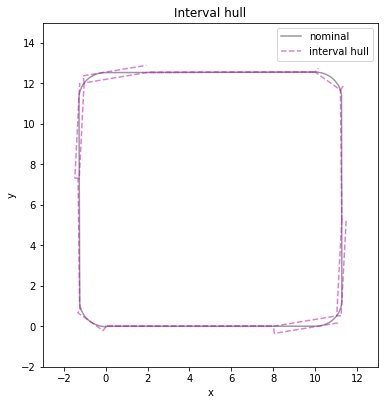

In [8]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-', alpha = 0.4)
for facet in range(n):
    hs_ch_s = ax.plot(intervalhull_s[facet][:,0], intervalhull_s[facet][:,1], color='m', linestyle='--', alpha =0.5)
    #hs_ch_l = ax.plot(intervalhull_l[facet][:,0], intervalhull_l[facet][:,1], color='y', linestyle='--')


title('Interval hull')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_s[0]], ['nominal', 'interval hull'], loc=1);
plt.xlim([-3, 13]);
plt.ylim([-2, 15]);




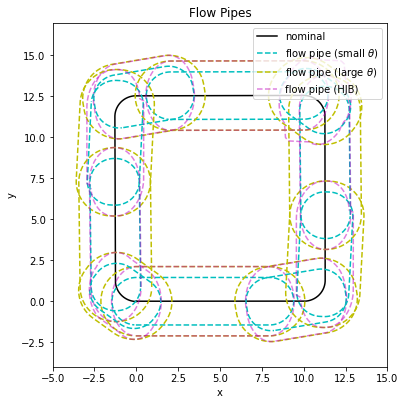

In [9]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_s = ax.plot(flow_pipes_s[facet][:,0], flow_pipes_s[facet][:,1], color='c', linestyle='--')
    hs_ch_l = ax.plot(flow_pipes_l[facet][:,0], flow_pipes_l[facet][:,1], color='y', linestyle='--')
    hs_ch_H = ax.plot(flow_pipes_H[facet][:,0], flow_pipes_l[facet][:,1], color='m', linestyle='--', alpha = 0.5)

title('Flow Pipes')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_s[0], hs_ch_l[0], hs_ch_H[0]], ['nominal', 'flow pipe (small $\\theta$)', 'flow pipe (large $\\theta$)','flow pipe (HJB)'], loc=1);
plt.xlim([-5, 15]);
plt.ylim([-4, 17]);